In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz

In [ ]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


# Data Reading

In [ ]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 24) \
    .config("spark.sql.shuffle.partitions", 24) \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/22 20:53:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Show the DataFrame to check if it's loaded correctly
df.show(10)

+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|0176496920| null|    5.0|Arrived on time, ...|01 23, 2013|A3FANY5GOT5X0W|    Kelly Keyser| null|  Just as described!|    1358899200|    true|null|
|0176496920| null|    5.0|This device was h...| 11 5, 2012| AT6HRPPYOPHMB|       Michael C| null|        Great device|    1352073600|    true|null|
|0176496920| null|    4.0|Just a clicker no...|10 17, 2012| A4IX7B38LIN1E|              BH| null|         Pretty Good|    1350432000|    true|null|
|0176496920| null|    5.0|Great response ca...|03 29, 2017|A12Q4LR8N17AOZ|   Waterfall3500| null|Thank you for t

In [ ]:
df.select("overall").summary("count").show()

+-------+-------+
|summary|overall|
+-------+-------+
|  count|  60676|
+-------+-------+



In [ ]:
df_meta.select("asin").summary("count").show()

+-------+------+
|summary|  asin|
+-------+------+
|  count|167442|
+-------+------+



In [ ]:
### load the meta data

df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [ ]:
df_meta.show(10)

+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|            also_buy|           also_view|      asin|               brand|            category|             date|         description|details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat| price|                rank|similar_item|               tech1|tech2|               title|
+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|[1454894547, 0133...|               

## Discussion



1.   We can not read some categories (especially those with large data, in this case, the sofrware category) directly in Spark; Need to figure out why and how to solve this. (Tried reading by in raw and use pandas and then spark, but this also failed.)
(I skipped this question by choosing another category which is fine to read directly)





# Data Pre-Processing and visulization

In [ ]:
# Drop the image column because I don't think we need it
df = df.drop('image')

In [ ]:
from pyspark.sql.functions import col, when, length, unix_timestamp, to_date

# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [ ]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    true|   4|              157|
|1587790637|    1.0|Very poor packagi...| 04 8, 2014|A39NP41GNG6DJT|  Nicole Ryan|{null, null, null...|Poster bent and w...|    1396915200| 

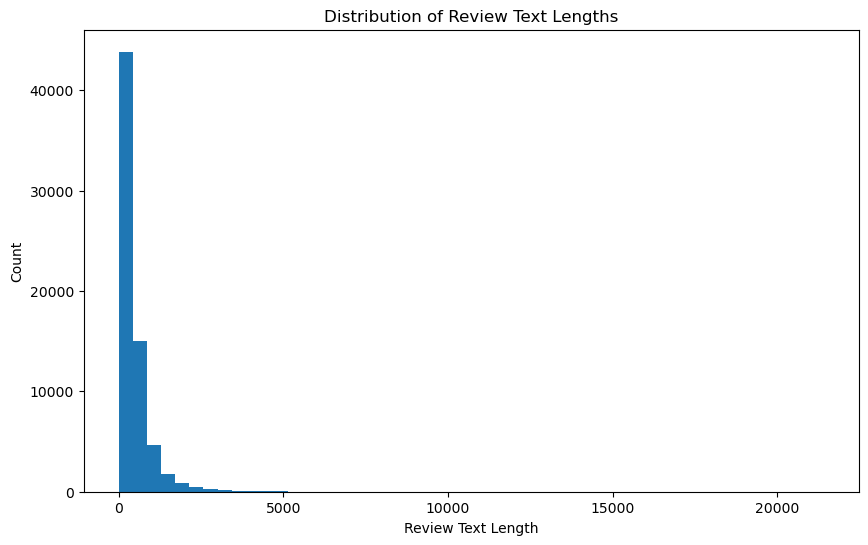

In [ ]:
import matplotlib.pyplot as plt

review_lengths = df.select('reviewText_length').rdd.flatMap(lambda x: x).collect()

# Now convert this list to a Pandas Series
pd_series = pd.Series(review_lengths)

# Plotting the distribution of reviewText_length using Pandas/Matplotlib
plt.figure(figsize=(10, 6))
pd_series.hist(bins=50)  # Adjust the number of bins for your specific dataset
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()

In [ ]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold

df = df.filter(col('reviewText_length') < 1000)  # Example threshold

In [ ]:
# Text Processing - cleaning the review text, tokenizing, and removing stop words (simplified example)
from pyspark.ml.feature import Tokenizer, StopWordsRemover
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
df = tokenizer.transform(df)
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
df = remover.transform(df)

In [ ]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    t

In [ ]:
from pyspark.sql.functions import when, col, length, split

# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

# Convert 'vote' to integer type
df = df.withColumn('vote', df['vote'].cast('int'))

In [ ]:
df.show(10)

+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|      asin|overall|          reviewText|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|Day|Month|Year|
+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|1587790637|    5.0|I love everything...| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...| 08|   3,|2014|
|1587790637|    2.0|Disappointed with...|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    t

In [ ]:
df.select('reviewerName').distinct().count()

44622

In [ ]:
df.select('asin').distinct().count()

7425

In [ ]:
from pyspark.sql.functions import avg, count

# Average rating
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

# Summary for vote column
votes_summary = df.describe(['vote'])



In [ ]:
# Count of reviews for each reviewer
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

In [ ]:
votes_summary

In [ ]:


# Convert Spark DataFrame to Pandas for Visualization
pdf = df.toPandas()
reviews_per_asin_pdf = reviews_per_asin.toPandas()

# Histogram for overall ratings
plt.figure(figsize=(10, 6))
pdf['overall'].hist()
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Plotting the pie chart for overall ratings
rating_counts = pdf['overall'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




In [ ]:

# Bar chart for number of reviews for each asin
top_reviews_per_asin_pdf = reviews_per_asin_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'asin' as the index and plot the 'review_count' column
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Bar chart for number of reviews for each reviewers
reviews_per_reviewers_pdf = reviews_per_reviewers.toPandas()

top_reviews_per_reviewers_pdf = reviews_per_reviewers_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'reviewers' as the index and plot the 'review_count' column
top_reviews_per_reviewers_pdf.set_index('reviewerID')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 reviewers')
plt.ylabel('Count')
plt.xlabel('reviewers')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Convert reviewText and summary columns to a single string
review_text_str = ' '.join(df.rdd.map(lambda row: row.reviewText).collect())
summary_str = ' '.join(df.rdd.map(lambda row: row.summary).collect())

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")


# Data Splitting

In [ ]:
## Data Splitting
from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)
# Add seed 1
(train, test) = df.randomSplit([0.8, 0.2],1)

## ALS (collabortaive filtering)
refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

# Fitting the ALS model on the training data
model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)


In [ ]:
rmse_train

In [ ]:
rmse_test

# GNN

In [1]:
!pip install torch torchvision
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.3/751.3 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 23.7 MB/s eta 0:00:00


In [1]:
# Standard library imports
import random
import time

# Third-party imports
# import networkx as nx
# pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import pandas as pd

In [2]:
# columns = ["overall","itemIndex","userIndex"]
# train = train.select(columns)
# test = test.select(columns)
# train_df = train.toPandas()
# test_df = test.toPandas()
train_df = pd.read_csv('gnn_train.csv')
test_df = pd.read_csv('gnn_test.csv')

In [36]:
# train_df.to_csv('gnn_train.csv',index = False)
test_df.to_csv('gnn_test.csv',index = False)

In [4]:
torch_geometric.__version__

'2.3.1'

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  48495
Test Size :  12181


In [7]:
# Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [9]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['userIndex'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['itemIndex'].values)

In [10]:
train_user_ids = train_df['userIndex'].unique()
train_item_ids = train_df['itemIndex'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['userIndex'].isin(train_user_ids)) & \
  (test_df['itemIndex'].isin(train_item_ids))
]
# test_df['user_known'] = test_df['userIndex'].isin(train_user_ids)
# test_df['item_known'] = test_df['itemIndex'].isin(train_item_ids)

print(len(test_df))

45634 6867
1305


In [11]:
test_df['user_id_idx'] = le_user.transform(test_df['userIndex'].values)
test_df['item_id_idx'] = le_item.transform(test_df['itemIndex'].values)

In [12]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  45634
Number of unique Items :  6867


In [14]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )
data_loader(train_df, 16, n_users, n_items)

(tensor([  514,  1263,  1764,  2275,  5739,  8809,  8841,  9254,  9620, 22817,
         23449, 23920, 28405, 40588, 44523, 45463], device='cuda:0'),
 tensor([45708, 45689, 47015, 45768, 46440, 46305, 45814, 48971, 46925, 45766,
         45849, 45669, 45800, 45936, 46123, 46177], device='cuda:0'),
 tensor([48731, 46207, 47642, 51806, 45872, 47513, 51969, 50882, 51525, 46055,
         52251, 49534, 48523, 50174, 45712, 50729], device='cuda:0'))

In [15]:
train_df.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

,user_id_idx,item_id_idx
0,0,"[2426, 1079, 573, 458, 458, 170, 3428, 2928]"
1,1,"[248, 480, 5017, 36, 36, 1737, 1737]"
2,2,"[50, 1903, 1903, 1184, 1184, 285, 4291, 5774]"
3,3,"[1172, 1905, 459, 459, 859, 1942, 5453]"
4,4,"[97, 99, 188, 849, 849, 1576, 282]"
...,...,...
45629,45629,[160]
45630,45630,[97]
45631,45631,[2636]
45632,45632,[1472]


In [26]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[29277,  5483, 31115,  ..., 50510, 50510, 52500],
        [48037, 48037, 48037,  ...,  2894,  2621, 39532]], device='cuda:0')

In [19]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
    # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [20]:
import numpy as np
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [17]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [16]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [21]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K = 10):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)
  # Compute F1-score
  metrics_df['f1_score'] = 2 * (metrics_df['precision'] * metrics_df['recall']) / (metrics_df['precision'] + metrics_df['recall'])
  metrics_df['f1_score'] = metrics_df['f1_score'].fillna(0)  # Handling undefined F1-score when precision and recall are both 0


  return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['f1_score'].mean()

In [22]:
latent_dim = 64
n_layers = 3

EPOCHS = 20
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 10

In [28]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  f1_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision,test_topK_f1 = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      f1_list.append(round(test_topK_f1,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list,
    f1_list
  )

In [29]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([52501, 64])]


In [30]:
light_loss, light_bpr, light_reg, light_recall, light_precision,light_f1 = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/20 [00:00<?, ?it/s]

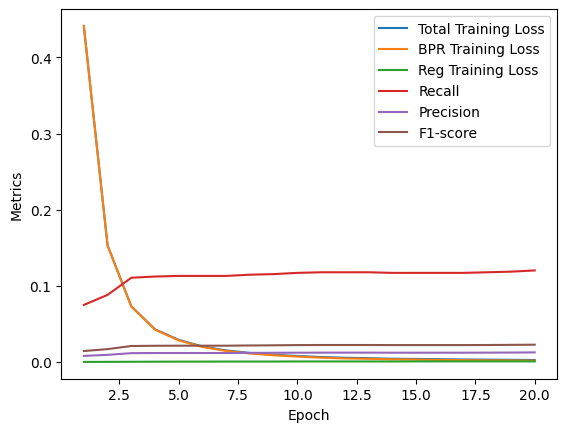

In [32]:
from matplotlib import pyplot as plt
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.plot(epoch_list, light_f1, label='F1-score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [33]:
max(light_precision), max(light_recall),max(light_f1)

(0.0127, 0.1203, 0.0228)

# Content-based Filtering

In [ ]:
df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [ ]:
df_meta.groupBy('price').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               price|count|
+--------------------+-----+
|                    |42683|
|.a-box-inner{back...| 1064|
|               $9.99|  953|
|               $7.99|  793|
|               $8.99|  666|
|               $6.99|  650|
|              $14.99|  647|
|              $19.99|  639|
|              $12.99|  621|
|              $15.99|  518|
|              $11.99|  516|
|               $5.99|  515|
|               $1.41|  498|
|              $13.99|  482|
|               $9.95|  478|
|               $4.99|  467|
|              $10.99|  467|
|              $29.99|  449|
|              $16.99|  399|
|              $12.95|  365|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df_meta.groupBy('brand').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|              uxcell| 7147|
|         Small Parts| 4252|
|   The Hillman Group| 1868|
|                    | 1302|
|           SmartSign| 1164|
|                  3M| 1021|
|                 VXB| 1003|
|               Brady|  866|
|     ComplianceSigns|  793|
|Hard-to-Find Fast...|  700|
|                SEOH|  680|
|   RAW PRODUCTS CORP|  660|
|           Fastenere|  608|
|             Generic|  582|
|              Vestil|  573|
|      D&D PowerDrive|  568|
|             Medline|  560|
|  Simpson Strong-Tie|  492|
|               EISCO|  487|
|             Hillman|  458|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import expr
from pyspark.sql import functions as F
from pyspark.sql.functions import mean
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

In [ ]:
# Step 1: The item profiles are already in 'df_transformed' as 'features'

from pyspark.sql.functions import avg, count, collect_list
from pyspark.sql.window import Window

# Replace null or empty strings with a placeholder
df_meta = df_meta.na.fill({"brand": "Unknown"})
df_meta = df_meta.withColumn("brand", F.when(F.col("brand") == "", "Unknown").otherwise(F.col("brand")))

# Step 1: Remove the dollar sign and try to convert the price to float
df_meta = df_meta.withColumn("price", regexp_replace(col("price"), "[\$,]", "").cast("float"))

# Step 2: Replace non-numeric (or negative) values with None, which Spark recognizes as null
df_meta = df_meta.withColumn("price", when(col("price") < 0, None).otherwise(col("price")))

# Step 3: Calculate the average of the numeric prices
average_price = df_meta.select(avg(col("price")).alias("avg_price")).collect()[0]["avg_price"]

# Step 4: Fill null values with the average price
df_meta = df_meta.na.fill({"price": average_price})


# Ensure the 'brand' column exists and does not have empty strings or null values
if 'brand' not in df_meta.columns:
    raise ValueError("'brand' column is missing from the DataFrame.")
if df_meta.filter((col('brand') == "") | (col('brand').isNull())).count() > 0:
    raise ValueError("'brand' column contains null or empty strings.")

# Ensure the 'price' column exists and has the correct data type
if 'price' not in df_meta.columns:
    raise ValueError("'price' column is missing from the DataFrame.")
if df_meta.filter(col('price').isNull()).count() > 0:
    df_meta = df_meta.fillna({'price': 0})  # Replace nulls with 0 in 'price' column

In [ ]:
df_meta.select('brand').distinct().count()

24124

In [ ]:
df_meta.groupBy('brand').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|              uxcell| 7147|
|         Small Parts| 4252|
|   The Hillman Group| 1868|
|             Unknown| 1742|
|           SmartSign| 1164|
|                  3M| 1021|
|                 VXB| 1003|
|               Brady|  866|
|     ComplianceSigns|  793|
|Hard-to-Find Fast...|  700|
|                SEOH|  680|
|   RAW PRODUCTS CORP|  660|
|           Fastenere|  608|
|             Generic|  582|
|              Vestil|  573|
|      D&D PowerDrive|  568|
|             Medline|  560|
|  Simpson Strong-Tie|  492|
|               EISCO|  487|
|             Hillman|  458|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Assuming 'train' and 'test' are the DataFrames resulting from splitting 'df',
# and 'df_meta' is the DataFrame containing the metadata

# Select the 'asin' from train and test DataFrames
train_asin = train.select('asin').distinct()
test_asin = test.select('asin').distinct()

# Join the metadata with the asin DataFrames to filter the rows
df_train = df_meta.join(train_asin, on='asin', how='inner')
df_test = df_meta.join(test_asin, on='asin', how='inner')

# Now df_train_meta and df_test_meta contain metadata for asins in the train and test sets respectively

In [ ]:
# Convert the 'price' column into a vector column
assembler_for_price = VectorAssembler(inputCols=["price"], outputCol="price_vector")

# Normalize the price column
price_scaler = MinMaxScaler(inputCol="price_vector", outputCol="price_scaled")

# Define the pipeline with all the stages
pipeline = Pipeline(stages=[
    # brand_indexer,
    # brand_encoder,
    assembler_for_price,
    price_scaler
    # assembler_for_features
])

# After cleaning, try fitting the pipeline again
pipeline_model = pipeline.fit(df_train)

# Now transform the data
df_transformed = pipeline_model.transform(df_train)

# Show the result
df_transformed.show()

23/11/08 12:42:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 12:42:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 12:42:18 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 12:42:18 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 12:42:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|      asin|            also_buy|           also_view|               brand|            category|              date|         description|             details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|   price|                rank|        similar_item|               tech1|tech2|               title|        price_vector|        price_scaled|
+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--

In [ ]:
df_transformed.select('price','price_scaled').show(10)

23/11/08 13:44:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+--------+--------------------+
|   price|        price_scaled|
+--------+--------------------+
|59.06999|[0.02023727012773...|
|59.06999|[0.02023727012773...|
|   18.09|[0.00610429032501...|
|   18.09|[0.00610429032501...|
|    3.98|[0.00123810182282...|
|    3.98|[0.00123810182282...|
|  132.49|[0.04555801005370...|
|  132.49|[0.04555801005370...|
|    3.99|[0.00124155057109...|
|    3.99|[0.00124155057109...|
+--------+--------------------+
only showing top 10 rows



23/11/08 13:45:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors, VectorUDT
# UDF to extract the first element of a vector column
first_element_udf = udf(lambda vector: float(vector[0]), FloatType())

df_transformed = df_transformed.withColumn("price_scaled_float", first_element_udf("price_scaled"))

23/11/08 13:49:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:50:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:50:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+------------------+
|      asin|            also_buy|           also_view|               brand|            category|              date|         description|             details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|   price|                rank|        similar_item|               tech1|tech2|               title|        price_vector|        price_scaled|price_scaled_float|
+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+---+------

In [ ]:
df_transformed.select('price','price_scaled_float').show(10)

23/11/08 13:51:01 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:51:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+--------+------------------+
|   price|price_scaled_float|
+--------+------------------+
|59.06999|        0.02023727|
|59.06999|        0.02023727|
|   18.09|      0.0061042905|
|   18.09|      0.0061042905|
|    3.98|      0.0012381019|
|    3.98|      0.0012381019|
|  132.49|        0.04555801|
|  132.49|        0.04555801|
|    3.99|      0.0012415505|
|    3.99|      0.0012415505|
+--------+------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, count, col, broadcast

df_train = df_transformed

# Use scaled priced instead

# Prepare the item profiles from the training set
item_profiles_train = df_train.select('asin', 'brand', 'price_scaled_float').distinct()

# Calculate the average price for each user in the training set
avg_price_train = train.join(df_train, 'asin').groupBy('reviewerID').agg(avg('price_scaled_float').alias('avg_price'))

# Count the occurrences of each brand for each user in the training set and find the most frequent one
brand_frequency_train = train.join(df_train, 'asin').groupBy('reviewerID', 'brand').agg(count('brand').alias('brand_count'))

# Find the top brand for each user in the training set
windowSpec = Window.partitionBy('reviewerID').orderBy(col('brand_count').desc(), col('brand'))
top_brands_train = (brand_frequency_train.withColumn('rank', F.row_number().over(windowSpec))
                    .where(col('rank') == 1)
                    .select('reviewerID', 'brand'))

# Create the user profiles using the training set
user_profiles_train = avg_price_train.join(broadcast(top_brands_train), 'reviewerID')

user_profiles_train.show(10)

23/11/08 13:51:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:51:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:51:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:51:47 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:51:47 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:51:50 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:51:50 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


+--------------+--------------------+--------------+
|    reviewerID|           avg_price|         brand|
+--------------+--------------------+--------------+
|A3LS2HKRVRYK9Q|0.045558009296655655|           Jet|
| A1M97ZR8OPE3I|0.032564262549082436|           Jet|
| A5KBLLLHVL65K|0.001241550548002...|Hy-Ko Products|
| AF3AZVK90T805|  0.0202372707426548|      J-B Weld|
|A1XKVW78IIGXP0|  0.0202372707426548|      J-B Weld|
|A3W4QHUMVXF8K1| 0.01973375678062439|      Shop-Vac|
|A3QMTWC08MPA9V| 0.01973375678062439|      Shop-Vac|
|A2FSU0FOYLVBU3| 0.01973375678062439|      Shop-Vac|
|A3977OZLNA8LCB| 0.00705384664858381|ARROW FASTENER|
|A3GJU3F1DAUFI8|0.002614153781905...|        Plymor|
+--------------+--------------------+--------------+
only showing top 10 rows



23/11/08 13:51:51 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


In [ ]:
item_profiles_train.show(10)

23/11/08 13:51:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:52:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:52:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+----------+-----------------+------------------+
|      asin|            brand|price_scaled_float|
+----------+-----------------+------------------+
|0971007004| Thomas McCracken|       0.004459236|
|B00004UDI2|           Dremel|      0.0024486135|
|B00008IHTK|         Starrett|        0.09261277|
|B0000DD1EE|          Steelex|        0.02023727|
|B00023RVP2|           Extech|      0.0035177267|
|B00024JE5Q|              TPI|        0.13449441|
|B0002BBV28|               3M|       0.008511519|
|B0002FU918|          Simonds|       0.008901228|
|B0002SQT7S|Milton Industries|        0.02023727|
|B0002ZPEX6|    Parts Express|      0.0025175887|
+----------+-----------------+------------------+
only showing top 10 rows



23/11/08 13:52:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import rank, col

# Assuming calculate_similarity can be replaced with a native Spark function or combination of functions
def calculate_similarity(user_brand, user_avg_price, item_brand, item_price):
    # Simple similarity based on brand matching and price difference
    brand_similarity = 1 if user_brand == item_brand else 0
    # Prevent division by zero if user_avg_price is 0
    price_similarity = 1 - abs(item_price - user_avg_price) / user_avg_price if user_avg_price != 0 else 0
    # Combine the two components of similarity
    return brand_similarity * 0.5 + price_similarity * 0.5

# Register the UDF
similarity_udf = F.udf(calculate_similarity, FloatType())

# Generate recommendations for users in the validation set
# First, get the list of items each user has reviewed in the training set to exclude them from recommendations
df_already_reviewed_train = train.select('reviewerID', 'asin').distinct().alias("ar_train")

# Calculate similarities between user profiles and item profiles, excluding already reviewed items
user_profiles_val = test.select('reviewerID').distinct().alias("up_val")
item_profiles_alias = item_profiles_train.alias("ip")

user_profiles_val = user_profiles_val.join(broadcast(user_profiles_train), "reviewerID", "inner")
user_profiles_val = user_profiles_val.alias("up_val")
user_item_similarity = (user_profiles_val
                        .crossJoin(broadcast(item_profiles_alias))
                        .withColumn('similarity', similarity_udf(
                            col('up_val.brand'), col('up_val.avg_price'), col('ip.brand'), col('ip.price_scaled_float')))
                        .select('up_val.reviewerID', 'ip.asin', 'similarity'))

# Exclude already reviewed items
recommendations = user_item_similarity.join(broadcast(df_already_reviewed_train),
                                            (user_item_similarity.reviewerID == df_already_reviewed_train.reviewerID) &
                                            (user_item_similarity.asin == df_already_reviewed_train.asin),
                                            'left_anti')

# Use window functions to rank by similarity
windowSpec = Window.partitionBy(recommendations['reviewerID']).orderBy(recommendations['similarity'].desc())

ranked_recommendations = recommendations.withColumn("rank", rank().over(windowSpec))

# Get top N recommendations
top_recommendations = ranked_recommendations.filter(col("rank") <= 10)  # Replace N with the number of recommendations you want


In [ ]:
top_recommendations.show(10)

23/11/08 13:52:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:52:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:52:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:52:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:08 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:53:08 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:53:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:11 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:53:12 WARN DAGScheduler: Broadcasting larg

+--------------+----------+----------+----+
|    reviewerID|      asin|similarity|rank|
+--------------+----------+----------+----+
|A11JM4NHFH7PLY|B009PPEVTW|0.98698884|   1|
|A11JM4NHFH7PLY|B00GT8ZHXW|0.98358124|   2|
|A11JM4NHFH7PLY|B005LDG7HQ| 0.9814127|   3|
|A11JM4NHFH7PLY|B00AWHS3D2| 0.9789343|   4|
|A11JM4NHFH7PLY|B007XU5UAU| 0.9736679|   5|
|A11JM4NHFH7PLY|B000PHGM14| 0.9677819|   6|
|A11JM4NHFH7PLY|B0010AZT3W| 0.9640644|   7|
|A11JM4NHFH7PLY|B017WO9TFI| 0.9615862|   8|
|A11JM4NHFH7PLY|B0012IYOH4|0.95600986|   9|
|A11JM4NHFH7PLY|B0070VF5P2| 0.9522924|  10|
+--------------+----------+----------+----+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import collect_list

# Assuming top_recommendations DataFrame has columns 'reviewerID' and 'asin'
final_recommendations = (top_recommendations
                         .groupBy('reviewerID')
                         .agg(collect_list('asin').alias('recommendations')))


In [ ]:
final_recommendations.show(1,truncate = False)

23/11/08 13:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:38:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:38:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:38:10 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:38:10 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:38:13 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:38:14 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:38:14 WARN DAGScheduler: Broadcasting larg

+--------------+------------------------------------------------------------------------------------------------------------------------+
|reviewerID    |recommendations                                                                                                         |
+--------------+------------------------------------------------------------------------------------------------------------------------+
|A11JM4NHFH7PLY|[B009PPEVTW, B00GT8ZHXW, B005LDG7HQ, B00AWHS3D2, B007XU5UAU, B000PHGM14, B0010AZT3W, B017WO9TFI, B0012IYOH4, B0070VF5P2]|
+--------------+------------------------------------------------------------------------------------------------------------------------+
only showing top 1 row



In [ ]:
actual_items.show(10)

23/11/08 13:56:38 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+--------------------+--------------------+
|          reviewerID|         actual_asin|
+--------------------+--------------------+
|A0575344WFZ4F94SHX4P|        [B00U3KF55C]|
|      A100X1V4Q37JW4|        [B012APXT96]|
|      A101NT6MFU94QU|        [B01DF31DQS]|
|      A1029V9OX0GBCT|        [B00AOVH60M]|
|      A102UVDIWPBMYM|        [B00OCSPCN6]|
|      A102XRGI4UFG99|[B0013TVEYS, B001...|
|      A102ZELP840AUD|        [B005Z4QWIK]|
|      A1032U0WM7J9GA|        [B00AXE5B3O]|
|      A1047EDJ84IMAS|        [B000S99LEO]|
|      A104EHYQV3IE1G|        [B0075E9T2Y]|
+--------------------+--------------------+
only showing top 10 rows



23/11/08 13:56:52 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [ ]:
from pyspark.sql.functions import col, size, array_intersect

# Step 1: For each `reviewerID` in `test`, collect all `asin` values into a list.
actual_items = test.groupBy('reviewerID').agg(collect_list('asin').alias('actual_asin'))

# Join the actual items with the recommended items on `reviewerID`
results = final_recommendations.join(actual_items, 'reviewerID')

# Step 3: Calculate true positives, precision, recall, and F1 score.
metrics = results.withColumn('true_positives', size(array_intersect(col('recommendations'), col('actual_asin')))) \
                 .withColumn('precision', col('true_positives') / size(col('recommendations'))) \
                 .withColumn('recall', col('true_positives') / size(col('actual_asin'))) \
                 .withColumn('F1', when((col('precision') + col('recall')) > 0,
                                         2 * (col('precision') * col('recall')) / (col('precision') + col('recall')))
                             .otherwise(0))

# Show the results
metrics.select('reviewerID', 'precision', 'recall', 'F1').show()


23/11/08 13:53:41 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:41 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:41 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:41 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:44 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 13:53:58 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:53:58 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 13:53:58 WARN DAGScheduler: Broadcasting larg

+--------------+-------------------+------+-------------------+
|    reviewerID|          precision|recall|                 F1|
+--------------+-------------------+------+-------------------+
|A11JM4NHFH7PLY|                0.0|   0.0|                0.0|
|A17MOXNUG5ZQTS|                0.0|   0.0|                0.0|
|A1AGCZQPZ9PZNR|                0.0|   0.0|                0.0|
|A1C5TCCR2IGKBU|                0.0|   0.0|                0.0|
|A1NKBMUSE0FK9O|                0.0|   0.0|                0.0|
|A1REI9L7HVFLD3|                0.0|   0.0|                0.0|
|A1S1RAEP3AUCTM|                0.0|   0.0|                0.0|
|A1UZ4KONK58IF1|                0.0|   0.0|                0.0|
|A1W415JP5WEAJK|                0.0|   0.0|                0.0|
|A1YIFPM15ZHNIV|                0.0|   0.0|                0.0|
|A20YQUOOUKMEYM|                0.0|   0.0|                0.0|
|A22CFBCRX195CD|                0.0|   0.0|                0.0|
|A24LLOOJ0YRR1Q|                0.0|   0

In [ ]:
from pyspark.sql.functions import max as ma
average_metrics = metrics.agg(
    ma(col('precision')).alias('avg_precision'),
    ma(col('recall')).alias('avg_recall'),
    ma(col('F1')).alias('avg_F1')
)
average_metrics.show()

23/11/08 15:45:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/11/08 15:45:50 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 15:45:50 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/11/08 15:45:50 WARN DAGScheduler: Broadcasting larg

+-------------+----------+-------------------+
|avg_precision|avg_recall|             avg_F1|
+-------------+----------+-------------------+
|          0.2|       1.0|0.33333333333333337|
+-------------+----------+-------------------+

